# DE and cluster analysis of samples S2 and S3

In [11]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import anndata2ri
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Read data

In [3]:
data_s2 = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/filtered_data_maxpool_processed.h5ad")
data_s3 = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")

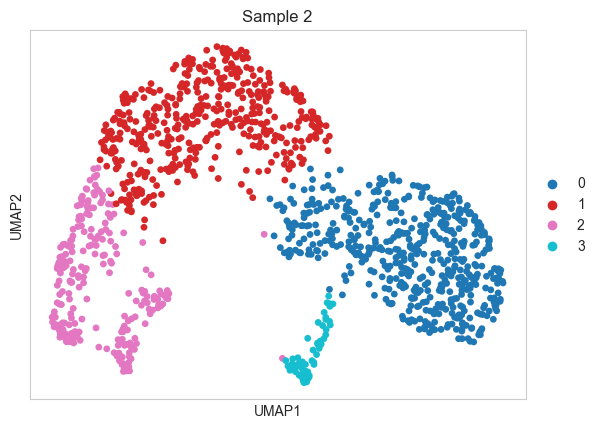

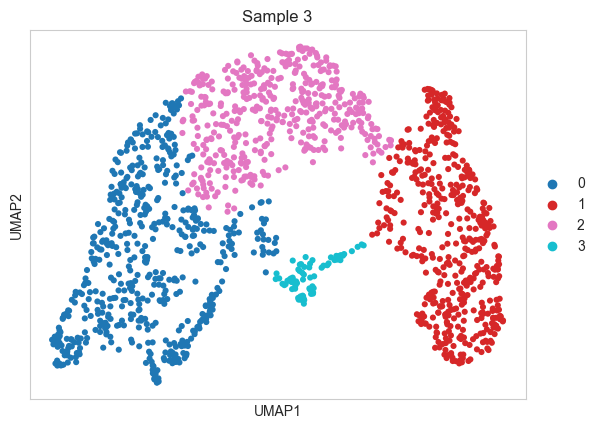

In [4]:
sc.pl.umap(data_s2, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()
sc.pl.umap(data_s3, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Differential expression testing with ClusterDE

### S3

In [6]:
data_s3

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [7]:
import tools.ClusterDE as cd

Construct synthetic null

In [8]:
cd.construct_synthetic_null(data_s3)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, row

Assay data with 5553 features for 1544 cells
First 10 features:
 PA0001, PA0002, PA0003, PA0004, PA0005, PA0006, PA0007, PA0008, PA0009,
PA0010 


R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 04:39


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 02:12


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 09:35


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:14


R[write to console]: New Data Generating End

R[write to console]: Warning:
R[write to console]:  Overwriting previous file ../../data/MOBA_scRNAseq/outs_S3/null_data.h5Seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA



In [10]:
data_null = ad.AnnData()

In [13]:
%%R -o data_null

suppressPackageStartupMessages(library(Seurat))
data.null <- LoadH5Seurat("null_data.h5Seurat")
data_null <- as.SingleCellExperiment(data.null)

data_null

class: SingleCellExperiment 
dim: 5553 1544 
metadata(0):
assays(2): counts logcounts
rownames(5553): PA0001 PA0002 ... PA5569 PA5570
rowData names(0):
colnames(1544): AAACCCAGTGGACCTC-1 AAACCCATCCTGTAGA-1 ...
  TTTGGTTTCGTTGTGA-1 TTTGTTGAGTAATACG-1
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding miscellaneous information for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


Processing of Null data

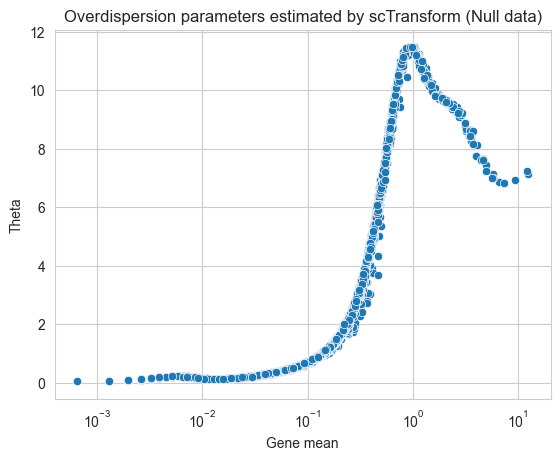

In [14]:
nb.estimate_overdisp_nb(data_null)
data_null.var["mean_counts"] = np.asarray(np.mean(data_null.X, axis=0)).squeeze()
g = sns.scatterplot(data=data_null.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform (Null data)")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [15]:
k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


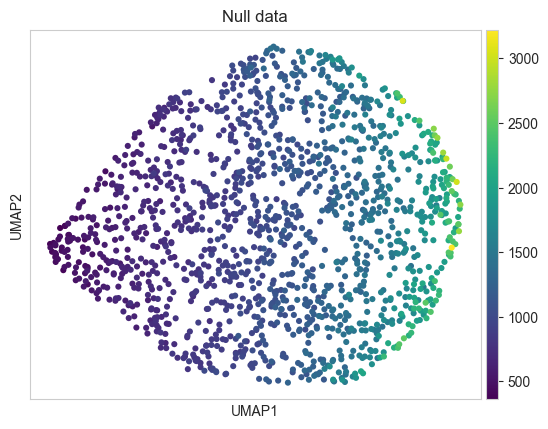

In [16]:
sc.pp.calculate_qc_metrics(data_null, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null, target_sum=None, layer=None)
data_null.X = sps.csr_matrix(np.log(data_null.X.toarray() + np.array(data_null.var["nb_overdisp_cutoff"] / 4)))
data_null.layers["vst_counts"] = data_null.X.copy()
sc.pp.scale(data_null, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_null, svd_solver='arpack')
sc.pp.neighbors(data_null, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

Cluster such that 2 clusters are generated

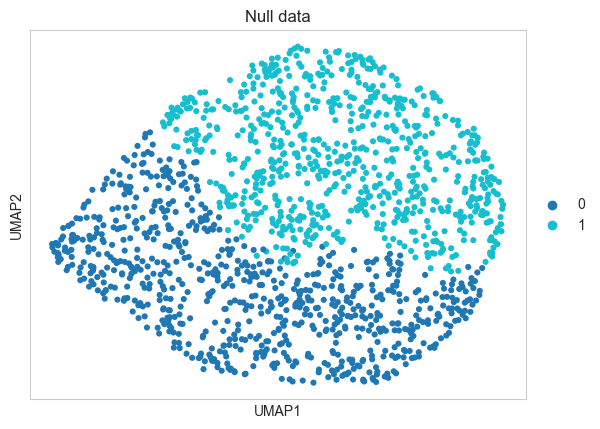

In [18]:
sc.tl.leiden(data_null, resolution=0.1, key_added="leiden", random_state=1234)
sc.pl.umap(data_null, color="leiden", palette="tab10", title="Null data")
plt.show()

Test cluster 3 vs. Rest for S3 data - Wilcoxon test

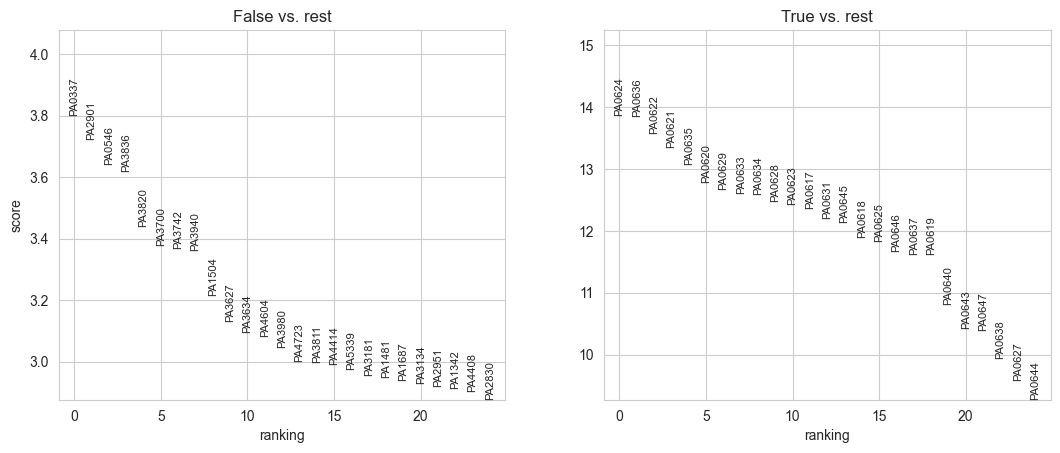

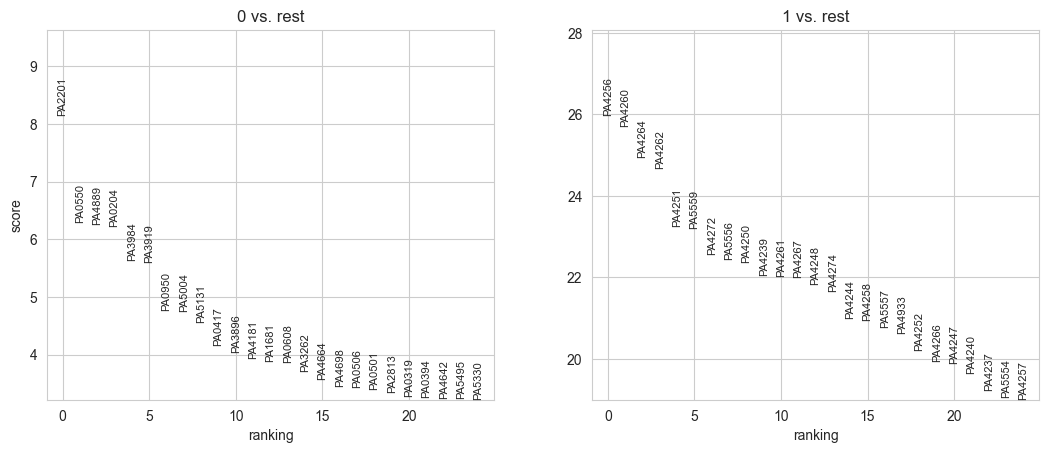

In [19]:
data_s3.obs["is_cluster_3"] = ([x == "3" for x in data_s3.obs["leiden_opt"]])
data_s3.obs["is_cluster_3"] = data_s3.obs["is_cluster_3"].astype("category")
sc.tl.rank_genes_groups(data_s3, 'is_cluster_3', method='wilcoxon')
sc.pl.rank_genes_groups(data_s3, n_genes=25, sharey=False)

sc.tl.rank_genes_groups(data_null, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data_null, n_genes=25, sharey=False)

Get p-values and do test adjustment

In [20]:
p_data = pd.DataFrame({"pval_data": [x[1] for x in data_s3.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_s3.uns["rank_genes_groups"]["names"]])
p_null = pd.DataFrame({"pval_null": [x[1] for x in data_null.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_null.uns["rank_genes_groups"]["names"]])


In [21]:
importlib.reload(cd)
DE_S3, pval_S3 = cd.call_de(p_data, p_null, FDR=0.05)

In [24]:
DE_S3[:10]

,pval_data,pval_null,cs,q
PA0624,42.992122,0.304900,42.687222,0.009451
PA0636,42.827053,0.716351,42.110702,0.009635
PA0622,41.173361,0.875702,40.297659,0.009818
PA0621,39.838780,0.063740,39.775040,0.010002
PA0635,38.280540,0.088249,38.192291,0.010369
PA0620,36.666702,0.645435,36.021267,0.010553
PA0629,36.010512,0.053038,35.957474,0.010553
PA0633,35.690598,0.180106,35.510492,0.010553
PA0634,35.539682,0.377031,35.162651,0.010553
PA0628,34.935605,0.182202,34.753402,0.010553


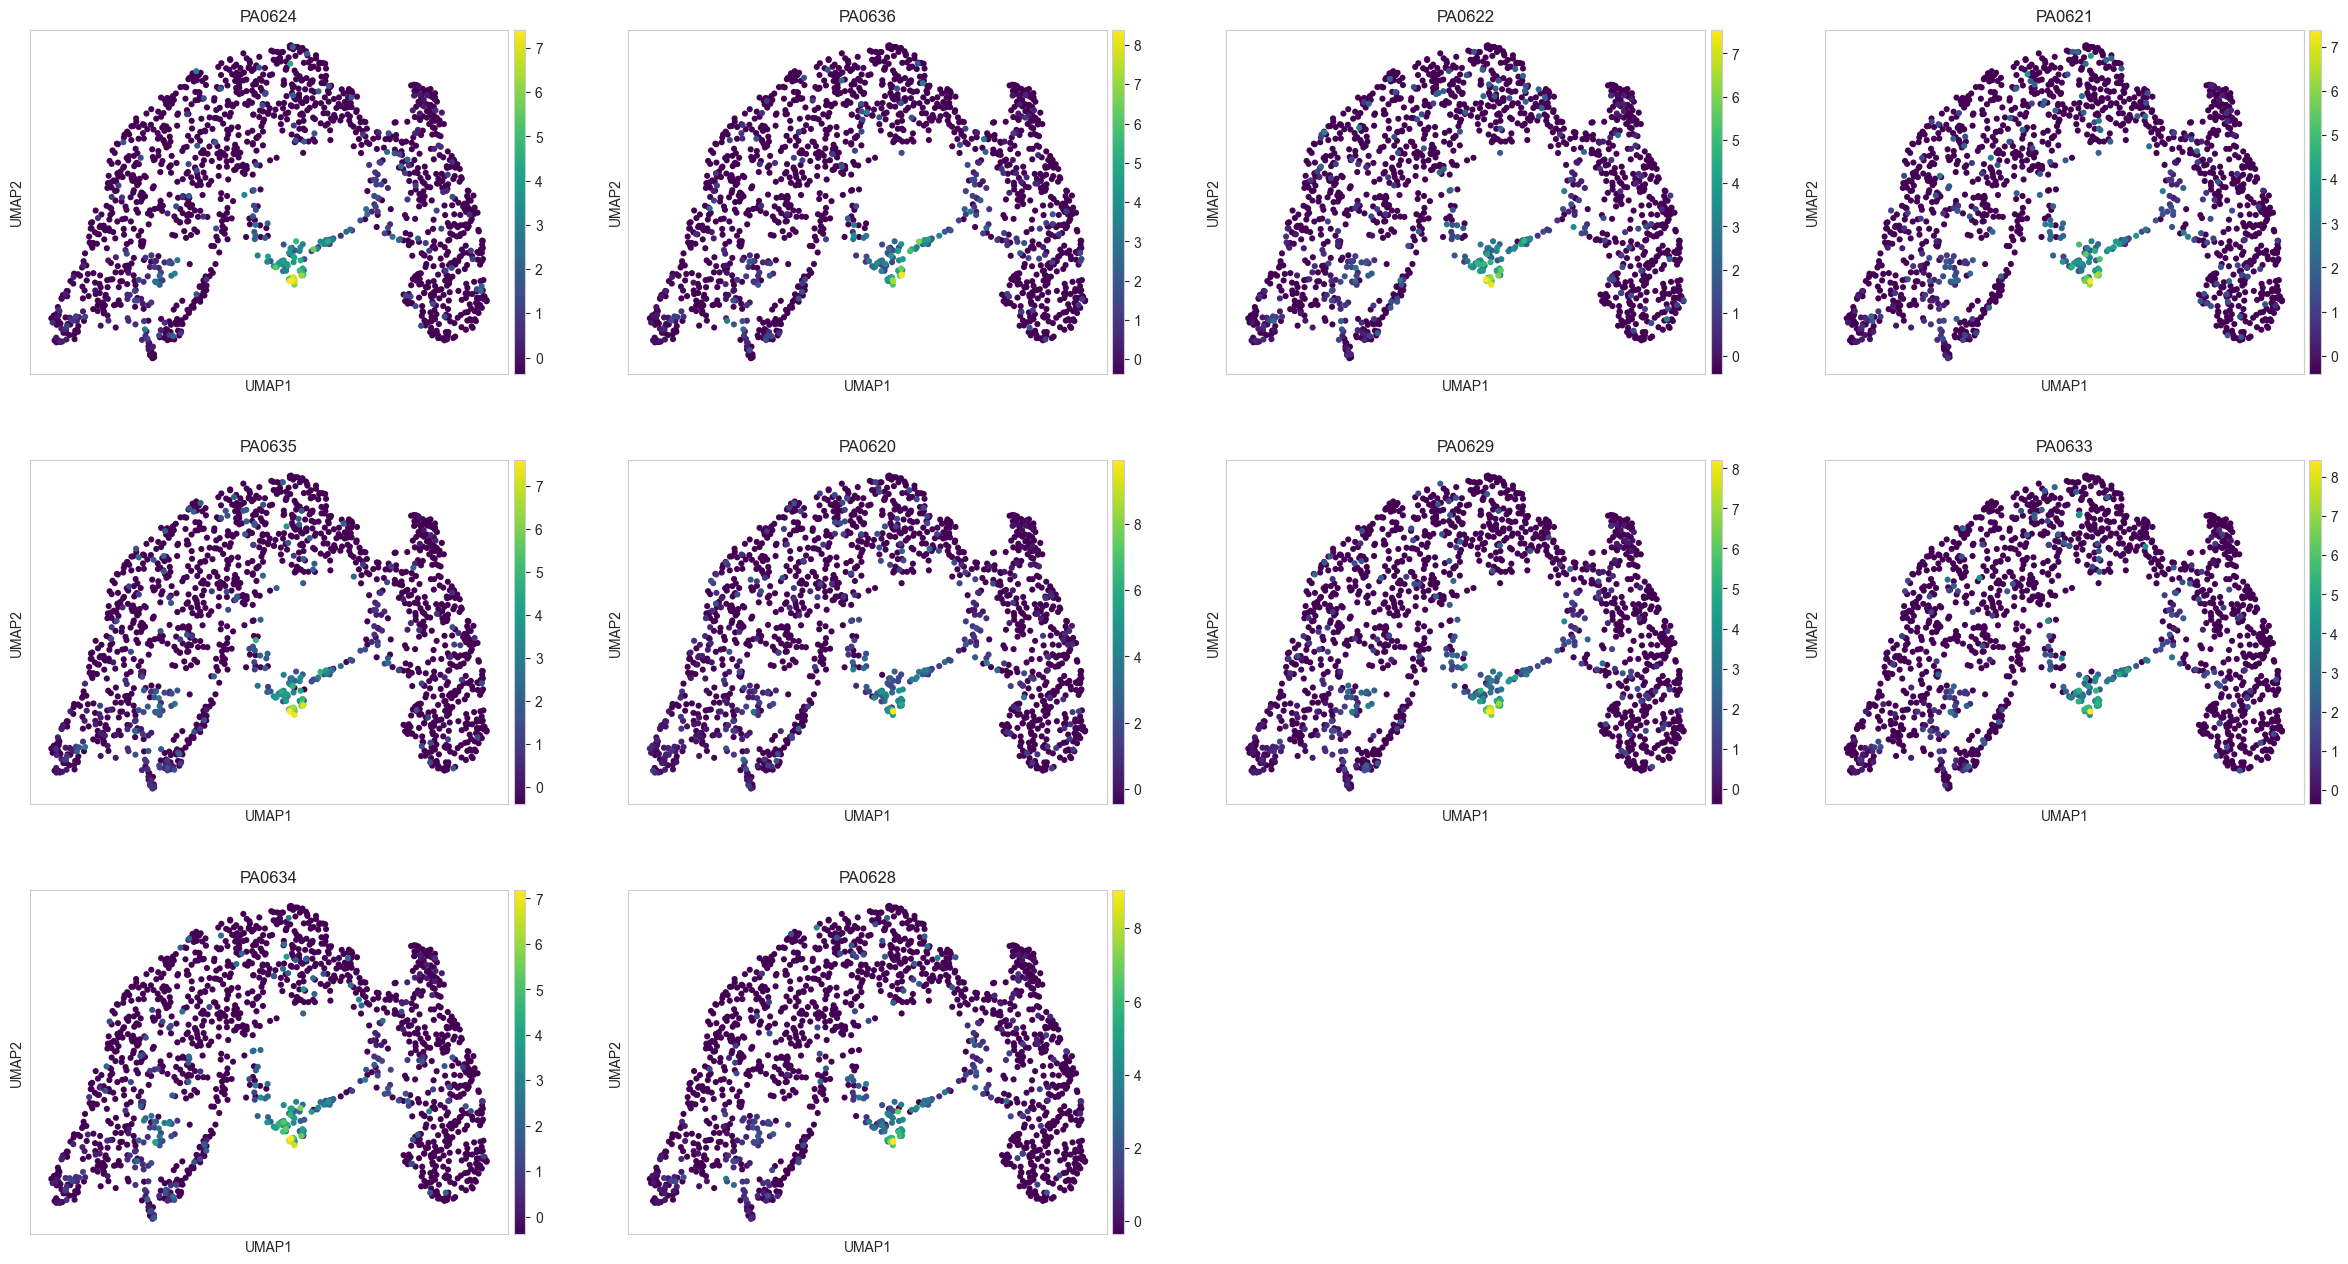

In [26]:
sc.pl.umap(data_s3, color=DE_S3[:10].index, palette="tab20", cmap="viridis")


In [33]:
DE_S3.index.values

array(['PA0624', 'PA0636', 'PA0622', 'PA0621', 'PA0635', 'PA0620',
       'PA0629', 'PA0633', 'PA0634', 'PA0628', 'PA0617', 'PA0623',
       'PA0631', 'PA0645', 'PA0618', 'PA0625', 'PA0646', 'PA0637',
       'PA0619', 'PA0640', 'PA0643', 'PA0647', 'PA0638', 'PA0627',
       'PA0615', 'PA0644', 'PA0626', 'PA0641', 'PA0630', 'PA0639',
       'PA0614', 'PA0616', 'PA0613', 'PA0911', 'PA0648', 'PA0910',
       'PA3866', 'PA0807', 'PA0546', 'PA0337', 'PA0908', 'PA3634',
       'PA0650', 'PA3836', 'PA5339', 'PA2901', 'PA3940', 'PA1150',
       'PA1504', 'PA0612', 'PA4693', 'PA1342', 'PA3820', 'PA3811',
       'PA4454', 'PA0657', 'PA4636', 'PA3816', 'PA0610', 'PA3980',
       'PA3627', 'PA2830', 'PA3019', 'PA3686', 'PA1156', 'PA0909',
       'PA4501', 'PA2800', 'PA1481', 'PA5148', 'PA2983', 'PA0332',
       'PA2620', 'PA2614', 'PA4604', 'PA3171', 'PA3257', 'PA0962',
       'PA2980'], dtype=object)

In [38]:
data_s3.var.loc[DE_S3.index, ["TU_ID", "Regulation - transcription units of gene"]]

,TU_ID,Regulation - transcription units of gene
PA0624,441,PA0624 // PA0623 // PA0622
PA0636,446,PA0639 // PA0638 // PA0637 // PA0636
PA0622,441,PA0624 // PA0623 // PA0622
PA0621,440,PA0621 // PA0620 // PA0619 // PA0618 // PA0617
PA0635,445,PA0635 // PA0634 // PA0633
...,...,...
PA4604,3084,PA4604 // PA4603
PA3171,2151,PA3172 // ubiG
PA3257,2210,PA3258 // prc
PA0962,680,PA0962
